# AT&T CNN
This example is trying the Databse of face from AT&T Lab Cambridge, using CNN to perform Face-recognitions
http://www.cl.cam.ac.uk/research/dtg/attarchive/facedatabase.html

## Imports

In [124]:
from IPython.display import Image
from PIL import Image as pilImage
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
import os
import time
import math
from sklearn.metrics import confusion_matrix
from datetime import timedelta

## Load Data

In [150]:
import ATT as att
from ATT import IMAGE_SIZE, NUM_CHANNELS, NUM_CLASSES
att.maybe_download_and_extract()
# Get Training data
train_image, train_cls, train_cls_one_hot = att.get_data(isTraining = True)
# Get Test data
test_image, test_cls, test_cls_one_hot = att.get_data(isTraining = False)

# img = Image.fromarray(t, 'L')
# img.show()

Data has already been extracted in previous session.
Training data acquire successfully!
The Training-set contain [320] images
Training data acquire successfully!
The Training-set contain [80] images


### Plot images
Some helper functions from the example to view part of the dataset

In [147]:
class_names = range(1,41)

def plot_images(images, cls_true, cls_pred=None, smooth=True):

    assert len(images) == len(cls_true) == 9

    # Create figure with sub-plots.
    fig, axes = plt.subplots(3, 3)

    # Adjust vertical spacing if we need to print ensemble and best-net.
    if cls_pred is None:
        hspace = 0.3
    else:
        hspace = 0.6
    fig.subplots_adjust(hspace=hspace, wspace=0.3)

    for i, ax in enumerate(axes.flat):
        # Interpolation type.
        if smooth:
            interpolation = 'spline16'
        else:
            interpolation = 'nearest'

        # Plot image.
        if NUM_CHANNELS == 1:
            ax.imshow(images[i, :, :, 0], interpolation=interpolation, cmap='gray')
        else:
            ax.imshow(images[i, :, :, :], interpolation=interpolation, cmap='gray')
            
        # Name of the true class.
        cls_true_name = class_names[cls_true[i]]
        
        # Show true and predicted classes.
        if cls_pred is None:
            xlabel = "True: {0}".format(cls_true_name)
        else:
            # Name of the predicted class.
            cls_pred_name = class_names[cls_pred[i]]

            xlabel = "True: {0}\nPred: {1}".format(cls_true_name, cls_pred_name)

        # Show the classes as the label on the x-axis.
        ax.set_xlabel(xlabel)
        
        # Remove ticks from the plot.
        ax.set_xticks([])
        ax.set_yticks([])
    
    # Ensure the plot is shown correctly with multiple plots
    # in a single Notebook cell.
    plt.show()

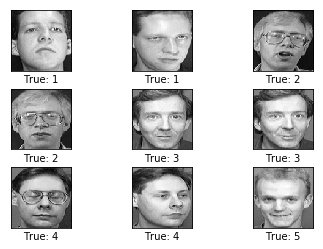

In [148]:
# Get the first images from the test-set.
images = test_image[0:9]
# Get the true classes for those images.
cls_true = test_cls[0:9]
# Plot the images and labels using our helper-function above.
plot_images(images=images, cls_true=cls_true, smooth=False)

## Setting Variables
### Placeholder variables

Everytime we execute the TensorFlow computational graph, we can feed different values to the Placeholder variables. These Placeholder variable are multi-dimensional array called <b>tensor</b> and the data-type is set to <b>float32</b>. 

<font color="red">**None means it can hold an arbitrary number of images.</font>
<br>The images input shape: [None, img_size, img_size, num_channels]
<br>- Each image being <b>img_size</b> pixels high and <b>img_size</b> pixels wide and with <b>num_channels</b> colour channels.
<br>The labels shape: [None, num_classes]
<br>The class shape: [None]

In [151]:
# TensorFlow expect 4-dim input X, so we have to reshape x
# Output: [num_images, img_height, img_width, num_channels]
# Note that all input is square, thus, img_height == img_width == img_size
# num_images can be inferred automatically by using -1 
x = tf.placeholder(tf.float32, shape=[None, IMAGE_SIZE, IMAGE_SIZE, NUM_CHANNELS], name='x')

# Label y associated with X 
# Output: [arbitrary, num_classes]
# 10 classes for eachd digit in this case
# Each example's class is represent in vector e.g. For class 5 = [0,0,0,0,0,1,0,0,0,0]
y_true = tf.placeholder(tf.float32, shape=[None, NUM_CLASSES], name='y_true')

# Class-number y associated with X 
# Output: [arbitrary]
# Each example's class is represent in number e.g. [5]
y_true_cls = tf.argmax(y_true, dimension=1)

### Helper Function
In ipython there is execution sequence, so all helper function should be execute before proceed. Different from previous practice, most helper-functions are grouped and placed in <b>/helper</b>.

**Note that the initialization is not actually done at this point, it defines the TensorFlow graph.